In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

bike_data_raw = pd.read_csv('daily-bike-share.csv')

In [2]:
bike_data_raw['dteday'] = pd.to_datetime(bike_data_raw['dteday'])

In [3]:
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)

In [4]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit']
target = 'rentals'

In [5]:
bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp'])/bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)
numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']
bike_data[['rentals', 'temp', 'difference_temp']].corr()

,rentals,temp,difference_temp
rentals,1.000000,0.543285,-0.310423
temp,0.543285,1.000000,-0.599254
difference_temp,-0.310423,-0.599254,1.000000


In [6]:
print(f'Numeric features: {numeric_features}')
print(f'Categorical features: {categorical_features}')
print(f'Target: {target}')

Numeric features: ['temp', 'difference_temp', 'hum', 'windspeed']
Categorical features: ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
Target: rentals


In [7]:
X = bike_data[['temp']].copy()
y = bike_data[target].copy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f'X.shape: {X.shape}, y.shape {y.shape}')
print()
print(f'X_train.shape: {X_train.shape}, y_train.shape {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape {y_test.shape}')

X.shape: (731, 1), y.shape (731,)

X_train.shape: (584, 1), y_train.shape (584,)
X_test.shape: (147, 1), y_test.shape (147,)


In [9]:
lr_model = LinearRegression() # inicjalizacja modelu
lr_model.fit(X_train, y_train) # trenowanie modelu

LinearRegression()

In [10]:
y_predict_train = lr_model.predict(X_train)
y_predict_test = lr_model.predict(X_test)

In [11]:
print(f'Train R^2: {r2_score(y_train, y_predict_train)}')

Train R^2: 0.30617863454631333


In [12]:
linear_MAE = [mean_absolute_error(y_train, y_predict_train), mean_absolute_error(y_test, y_predict_test)]
linear_MAPE = [mean_absolute_percentage_error(y_train, y_predict_train), mean_absolute_percentage_error(y_test, y_predict_test)]
linear_MSE = [mean_squared_error(y_train, y_predict_train), mean_squared_error(y_test, y_predict_test)]
linear_RMSE = [sqrt(mean_squared_error(y_train, y_predict_train)), sqrt(mean_squared_error(y_test, y_predict_test))]

In [13]:
cv = KFold(n_splits=5, shuffle=False)

In [14]:
# Podział na zmienne objaśniające i zmienną objaśnianą
X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

# Podział na zbiór treningowy i testowy (taki sam podział co poprzednio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Tworzenie końcowego Pipeline, który będziemy trenować
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)

final_polynomial_regression_gridsearch.fit(X_train, y_train)
print("\nNajlepsze hiperparametry:", final_polynomial_regression_gridsearch.best_params_, "\n")
y_predict_train = final_polynomial_regression_gridsearch
final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_
predictions_p1 = final_polynomial_regression_model.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions_p1))}')

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.169e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea


Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.4} 

RMSE: 483.9379414050111


### Policz pozostałe metryki dla tego modelu, zrób wizualizacyjną ocenę i następnie porównaj ostatni model z pierwszym, który stworzyliśmy. Link do swojego Notebooka w GitHubie prześlij swojemu Mentorowi.

In [22]:
y_predict_train = y_predict_train.predict(X_train)

In [23]:
poly_MAE = [mean_absolute_error(y_train, y_predict_train), mean_absolute_error(y_test, predictions_p1)]
poly_MAPE = [mean_absolute_percentage_error(y_train, y_predict_train),mean_absolute_percentage_error(y_test, predictions_p1)]
poly_MSE = [mean_squared_error(y_train, y_predict_train), mean_squared_error(y_test, predictions_p1)]
poly_RMSE = [sqrt(mean_squared_error(y_train, y_predict_train)), sqrt(mean_squared_error(y_test, predictions_p1))]

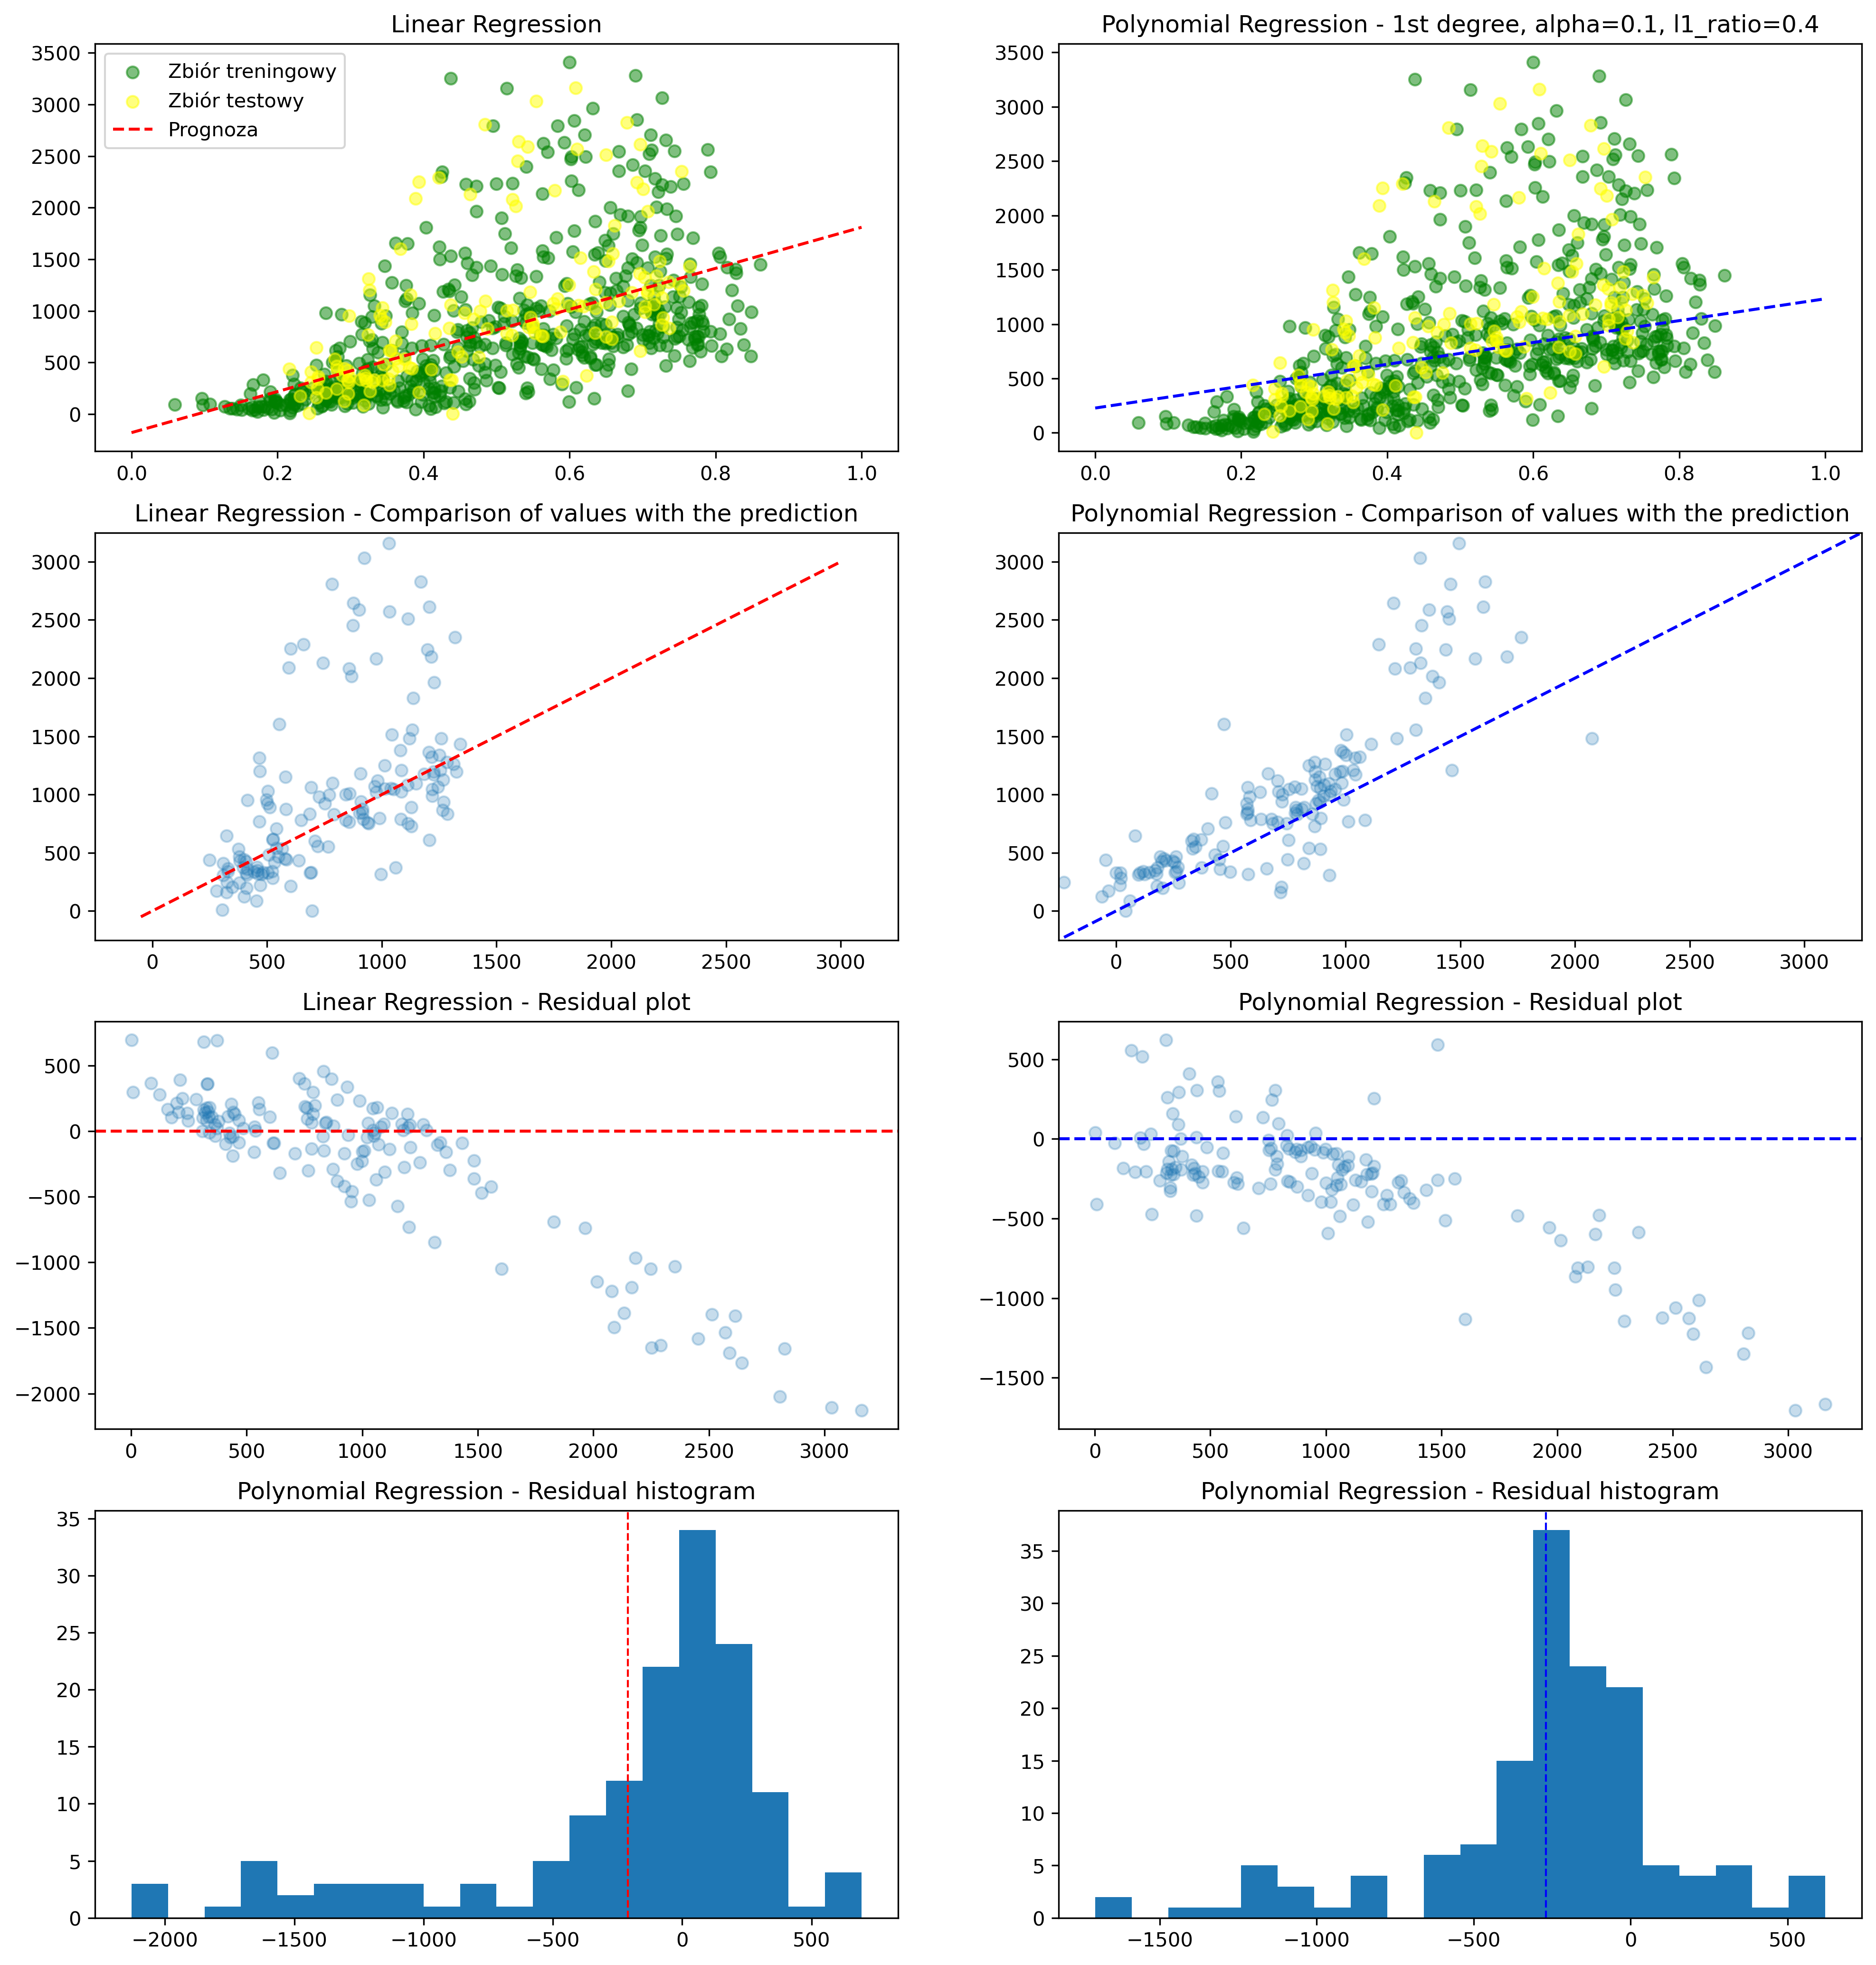

In [24]:
f = plt.figure(figsize=(16,26),dpi=300)

# axs[0]
X = bike_data[['temp']].copy()
y = bike_data[target].copy()
X_linspace = np.linspace(0, 1, 100)
y_fitted = lr_model.intercept_ + lr_model.coef_ * X_linspace
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Rysowanie wykresu
axs3 = f.add_subplot(621)
axs3.title.set_text('Linear Regression')
axs3.scatter(X_train, y_train, color='green', alpha=0.5, label='Zbiór treningowy')
axs3.scatter(X_test, y_test, color='yellow', alpha=0.5, label='Zbiór testowy')
axs3.plot(X_linspace, y_fitted, color='r', label='Prognoza', linestyle="--")
axs3.legend(loc='upper left')

# axs[1]
x_ax = np.linspace(0, 1, len(predictions_p1))
line = np.poly1d(np.polyfit(x_ax, predictions_p1[::-1], deg=1))

# Rysowanie wykresu
axs4 = f.add_subplot(622)

axs4.title.set_text('Polynomial Regression - 1st degree, alpha=0.1, l1_ratio=0.4')
axs4.plot(x_ax, line(x_ax), color='blue', linestyle="--")
axs4.scatter(X_train, y_train, color='green', alpha=0.5, label='Zbiór treningowy')
axs4.scatter(X_test, y_test, color='yellow', alpha=0.5, label='Zbiór testowy')

# axs[2]
axs5 = f.add_subplot(623)
axs5.axis(ymin=-250, ymax=3250, xmin=-250, xmax=3250)
axs5.scatter(x = y_predict_test, y = y_test, alpha=0.25)
b, a = np.polyfit(lr_model.predict(X_train), lr_model.predict(X_train), deg=1)
xseq = np.linspace(-50, 3000, num=3000)
axs5.title.set_text('Linear Regression - Comparison of values with the prediction')
axs5.plot(xseq, a + b * xseq, color="red", linestyle="--", lw=1.5);


# axs[4]
axs6 = f.add_subplot(624)
x = range(-50,3050)
axs6.axis(ymin=-250, ymax=3250, xmin=-250, xmax=3250)
axs6.scatter(x = predictions_p1, y = y_test, alpha=0.25)
axs6.title.set_text('Polynomial Regression - Comparison of values with the prediction')
axs6.plot(line(x), line(x), color='blue', linestyle="--")


# axs[5]
axs7 = f.add_subplot(625)
errors1 = y_predict_test - y_test
axs7.scatter(x = y_test, y = errors1, alpha=0.25)
axs7.axhline(0, color="r", linestyle="--")
axs7.title.set_text('Linear Regression - Residual plot')


# axs[6]
axs8 = f.add_subplot(626)
errors2 = predictions_p1 - y_test
axs8.scatter(x = y_test, y = errors2, alpha=0.25)
axs8.axhline(0, color="blue", linestyle="--")
axs8.title.set_text('Polynomial Regression - Residual plot')


# axs[7]
axs9 = f.add_subplot(627)
axs9.hist(errors1, bins = 20)
axs9.axvline(errors1.mean(), color='r', linestyle='dashed', linewidth=1)
axs9.title.set_text('Polynomial Regression - Residual histogram')


# axs[8]
axs10 = f.add_subplot(628)
axs10.hist(errors2, bins = 20)
axs10.axvline(errors2.mean(), color='blue', linestyle='dashed', linewidth=1)
axs10.title.set_text('Polynomial Regression - Residual histogram')

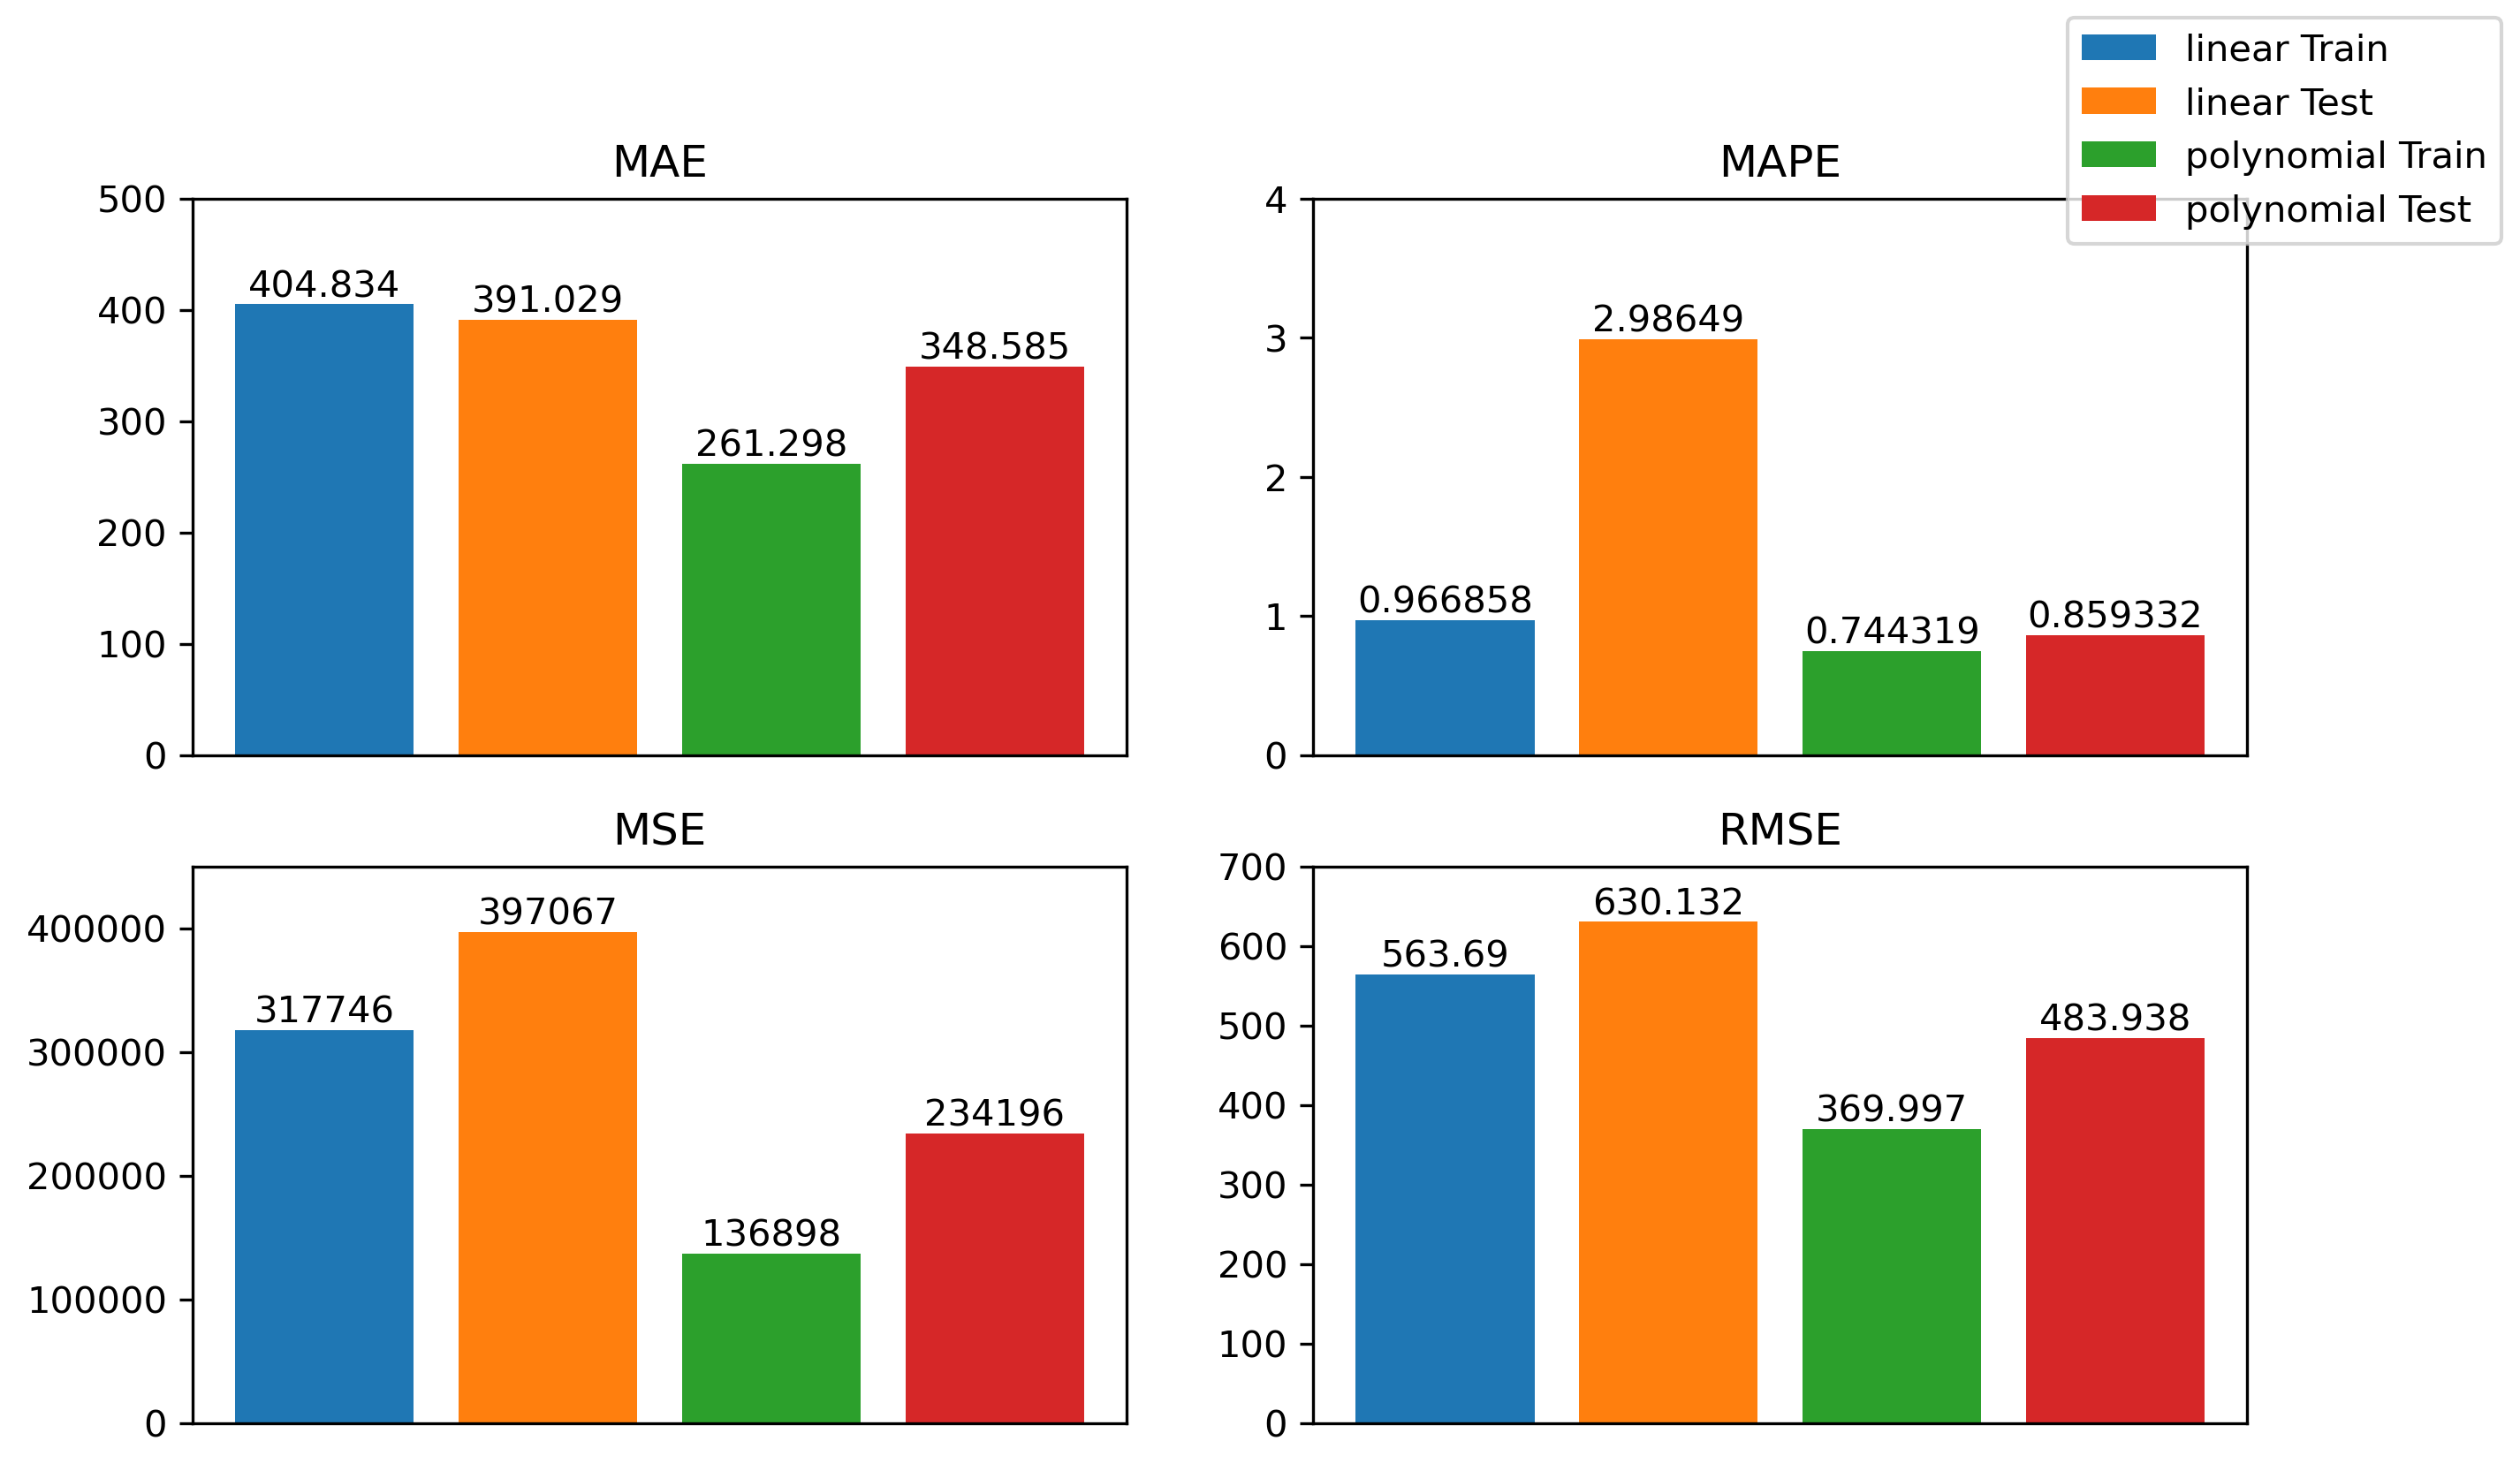

In [25]:
f = plt.figure(figsize=(10,6),dpi=300)

#1

axs1 = f.add_subplot(221)
axs1.title.set_text('MAE')
axs1.bar(1, linear_MAE[0], label='linear Train')
axs1.bar(2, linear_MAE[1], label='linear Test')
axs1.bar(3, poly_MAE[0], label='polynomial Train')
axs1.bar(4, poly_MAE[1], label='polynomial Test')
axs1.axis(ymin=0, ymax=500)
axs1.get_xaxis().set_visible(False)

for bars in axs1.containers:
    axs1.bar_label(bars)

#2

axs2 = f.add_subplot(222)
axs2.title.set_text('MAPE')
axs2.bar(1, linear_MAPE[0])
axs2.bar(2, linear_MAPE[1])
axs2.bar(3, poly_MAPE[0])
axs2.bar(4, poly_MAPE[1])
axs2.axis(ymin=0, ymax=4)
axs2.get_xaxis().set_visible(False)

for bars in axs2.containers:
    axs2.bar_label(bars)    

#3

axs3 = f.add_subplot(223)
axs3.title.set_text('MSE')
axs3.bar(1, linear_MSE[0])
axs3.bar(2, linear_MSE[1])
axs3.bar(3, poly_MSE[0])
axs3.bar(4, poly_MSE[1])
axs3.axis(ymin=0, ymax=4.5*10**5)
axs3.get_xaxis().set_visible(False)

for bars in axs3.containers:
    axs3.bar_label(bars)    

#4

axs4 = f.add_subplot(224)
axs4.title.set_text('RMSE')
axs4.bar(1, linear_RMSE[0])
axs4.bar(2, linear_RMSE[1])
axs4.bar(3, poly_RMSE[0])
axs4.bar(4, poly_RMSE[1])
axs4.axis(ymin=0, ymax=700)
axs4.get_xaxis().set_visible(False)

for bars in axs4.containers:
    axs4.bar_label(bars)   
    
    
f.legend()

<font color="green"><b>Biorąc pod uwagę obie regresje:</b></font>
<font color="green"><b>    
    - liniową,</b></font>
<font color="green"><b>    
    - wielomianową / ze zmiennymi kategorycznymi</b></font>
    
<font color="green"><b>
Można spostrzec kilka interesujących zależności.<br><br>Pierwszą z nich jest ocena MAE:

Wartości Treningowe:
- 404.83 dla modelu liniowego,
- 261.29 dla modelu wielomianowego - przy zastosowaniu hiperparametrów - stopień 1, alfa 0,1 i l1 0,4.

Wartości Testowe:
- 391.02 dla modelu liniowego,
- 348.58 dla modelu wielomianowego - przy zastosowaniu hiperparametrów - stopień 1, alfa 0,1 i l1 0,4.

Obliczenia wskaźników sugerują większe dopasowanie modelu wielomianowego do wartości treningowych oraz testowych.
Średni błąd absolutny informuje, że regresja wielomianowa średnio lepiej przybliża dla wartości treningowych oraz testowych.
<font color="green"><b>    
Druga z nich jest ocena MAPE:
    
Wartości Treningowe:
- 0.96 dla modelu liniowego,
- 0.74 dla modelu wielomianowego - przy zastosowaniu hiperparametrów - stopień 1, alfa 0,1 i l1 0,4.

Wartości Testowe:    
- 2.98 dla modelu regresji liniowej,
- 0.85 dla regresji wielomianowej - przy zastosowaniu hiperparametrów - stopień 1, alfa 0,1 i l1 0,4.
  
Obliczenia wskaźników sugerują większe dopasowanie modelu wielomianowego do wartości treningowych oraz testowych.
Średni błąd procentowy informuje, że regresja wielomianowa średnio lepiej przybliża dla wartości treningowych oraz testowych.
Wskaźnik ten w mojej ocenie jest lepszym kryterium oceny. Można zauważyć, że wyniki testowe dla wielomianu są niższe niż treningowe dla regresji liniowej. Niezrozumiałe są jednak wyniki dla regresji liniowej dla wartości testowych w porównaniu z wynikiem dla wskaźnika MAE - we wskaźniku MAPE mamy 300% a wynik dla MAE wartości testowych jest niższy niż treningowych. Skąd taki wynik dla MAPE?
    
<font color="green"><b>    
Druga z nich jest ocena MSE:
    
Wartości Treningowe:
- w obu przypadkach wynoszą 317746,

Wartości Testowe:    
- 397067 dla modelu regresji liniowej,
- 234196 dla regresji wielomianowej - przy zastosowaniu hiperparametrów - stopień 1, alfa 0,1 i l1 0,4.

Rozumiem, że ten wskaźnik średnich błędów kwadratowych ma za zadanie uwypuklić wzrost niedoszacowania wariancji. Pokazany jest problem niedoszacowania jej dla reghresji liniowej. W regresji wielomianowej jest już to znacznie ograniczone.
Dodatkowo rozumiem, że błędy te występują w znacznej mierze przy wyższych wartościach stąd tak znaczny wzrost wskaźnika dla regresji liniowej.
    
<font color="green"><b>    
Ostatecznie z nich jest ocena RMSE:
        
Wartości Treningowe:
- w obu przypadkach wynoszą 563.69,

Wartości Testowe:    
- 630.13 dla modelu regresji liniowej,
- 483.93 dla regresji wielomianowej - przy zastosowaniu hiperparametrów - stopień 1, alfa 0,1 i l1 0,4.

Pierwiastek błędu średniokwadratowego w zestawieniu z wynikami z MAE jest potwierdzeniem wyników dla MSE. Błędy dla dużych wartości są zredukowane więc i pierwiastek błędu średniokwadratowego będzie niższy dla regresji wielomianowej. Nawet w tym wypadku jest zbliżony do średnich błędów absolutnych dla regresji liniowej.
Myślę, że jest to ostateczny dowód na redukcję "dużych błędów".
    
<font color="green"><b>
Wykresy dotyczące "Comparison of values with the prediction":

- regresja liniowa:
w tym wypadku wartości przewiodywane są w granicy do około 1000.
    
- regresja wielomianowa:
przy wielomianie 1 stopnia i współczynniku alfa 0.1 i l1 0.4 widać, że przewidywanie dla wyższych wartości - do około 1000 - przebiega zgodnie z linią pokazującą wartości modelu (różnica między predykcją, a prawdziwymi wartościami jest mniejsza niż w modelu liniowym).

<font color="green"><b> 
Jednak:
Wykres reszt - "Residuial plot"

- regresja liniowa:
wykres ukazuje brak odwzorowania wariancji - widoczna jest tendencja liniowa (im wyższe wartości tym większe różnice między wartościami przewidywanymi a prawdziwymi)
    
- regresja wielomianowa:
na wykresie widoczna jest poprawa odwzorowania wariancji - do koło 1200 - wartości posiadają nieduże reszty, dopiero dla wyższych wartości następuje tendencja do niedoszacowywania.
 

<font color="green"><b>
Ostatecznie:
Wykres reszt - "Residuial plot"
   
Potwierdza to także histogram reszt którego średnia przecina się z medianą. W dalszym ciągu jest niedoszacowanie, ale bardziej odwzorowana jest wariancja. Interesujące jest to, że średnia i mediana reszt jest wyższa (ze znakiem ujemnym) dla wielomianu 1 stopnia. Wydaje mi się, że mimo to błędy są mniejsze niż w przypadku większej ilości błędów "grubych" dla modelu regresji liniowej.